Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4709 - loss: 0.9232 - val_accuracy: 0.5596 - val_loss: 0.8782
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5416 - loss: 0.9064 - val_accuracy: 0.5688 - val_loss: 0.8778
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5070 - loss: 0.9065 - val_accuracy: 0.5596 - val_loss: 0.8780
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5555 - loss: 0.8794 - val_accuracy: 0.5596 - val_loss: 0.8721
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5565 - loss: 0.8789 - val_accuracy: 0.5505 - val_loss: 0.8667
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6057 - loss: 0.8596 - val_accuracy: 0.6055 - val_loss: 0.8610
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5849 - loss: 0.8622 - val_accuracy: 0.5963 - val_loss: 0.8589
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5440 - loss: 0.8689 - val_accuracy: 0.6055 - v

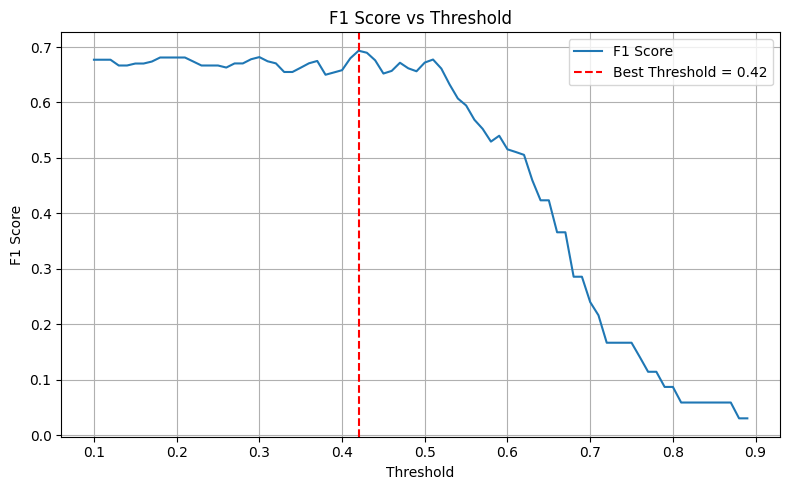

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Load dataset
df = pd.read_csv("deforestation_ml_dataset_cleaned.csv")
df[['25', '4']] = df[['25', '4']].fillna(0)

# Features and target
features = ['3', '6', '11', '15', '24', '33', '12', '25', '4', 'prev_count']
X = df[features]
y = df['target_increase']

# Train/val/test split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, stratify=y_train_val, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

# Class weights
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

# Build model
model = keras.Sequential([
    layers.Input(shape=(X_train_s.shape[1],)),
    layers.Dense(256, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),
    layers.Dense(128, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
optimizer = keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

# Train model
model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1
)

# Predict probabilities
y_prob = model.predict(X_test_s).flatten()

# F1 score for thresholds
thresholds = np.arange(0.1, 0.9, 0.01)
f1s = [f1_score(y_test, y_prob > t) for t in thresholds]
best_t = thresholds[np.argmax(f1s)]
y_pred = (y_prob > best_t).astype(int)

# Metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)

# Report
print("✅ Best Threshold:", round(best_t, 3))
print("Accuracy:", round(acc, 3))
print("F1 Score:", round(f1, 3))
print("ROC-AUC:", round(roc, 3))
print("Confusion Matrix:\n", cm)

# Plot F1 vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1s, label='F1 Score')
plt.axvline(best_t, color='r', linestyle='--', label=f'Best Threshold = {best_t:.2f}')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()